In [2]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder, FrozenOpenCLIPEmbedder2
from generative_models.sgm.models.diffusion import DiffusionEngine
from generative_models.sgm.util import append_dims
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils
from models import *

accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
device = accelerator.device
print("device:",device)

/home/users/ywei13/.conda/envs/playground/lib/python3.11/site-packages/rotary_embedding_torch/rotary_embedding_torch.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/users/ywei13/.conda/envs/playground/lib/python3.11/site-packages/rotary_embedding_torch/rotary_embedding_torch.py:258: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


device: cuda


In [11]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "singlesubject_subj01_40sess_prior"
    print("model_name:", model_name)

    # other variables can be specified in the following string:
    jupyter_args = f"--data_path=/data/users1/ywei/data/NSD \
                    --cache_dir=/data/users1/ywei/data/NSD/.cache \
                    --model_name={model_name} --subj=1 \
                    --hidden_dim=1024 --n_blocks=4 --new_test"
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: singlesubject_subj01_40sess_prior
--data_path=/data/users1/ywei/data/NSD                     --cache_dir=/data/users1/ywei/data/NSD/.cache                     --model_name=singlesubject_subj01_40sess_prior --subj=1                     --hidden_dim=1024 --n_blocks=4 --new_test
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="will load ckpt for model found in ../train_logs/model_name",
)
parser.add_argument(
    "--data_path", type=str, default=os.getcwd(),
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--cache_dir", type=str, default=os.getcwd(),
    help="Path to where misc. files downloaded from huggingface are stored. Defaults to current src directory.",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=False,
)
parser.add_argument(
    "--n_blocks",type=int,default=4,
)
parser.add_argument(
    "--hidden_dim",type=int,default=1024,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--seed",type=int,default=42,
)
if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

# make output directory
os.makedirs("evals",exist_ok=True)
os.makedirs(f"evals/{model_name}",exist_ok=True)

In [5]:
voxels = {}
# Load hdf5 data for betas
f = h5py.File(f'{data_path}/betas_all_subj0{subj}_fp32_renorm.hdf5', 'r')
betas = f['betas'][:]
betas = torch.Tensor(betas).to("cpu")
num_voxels = betas[0].shape[-1]
voxels[f'subj0{subj}'] = betas
print(f"num_voxels for subj0{subj}: {num_voxels}")

if not new_test: # using old test set from before full dataset released (used in original MindEye paper)
    if subj==3:
        num_test=2113
    elif subj==4:
        num_test=1985
    elif subj==6:
        num_test=2113
    elif subj==8:
        num_test=1985
    else:
        num_test=2770
    test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
else: # using larger test set from after full dataset released
    if subj==3:
        num_test=2371
    elif subj==4:
        num_test=2188
    elif subj==6:
        num_test=2371
    elif subj==8:
        num_test=2188
    else:
        num_test=3000
    test_url = f"{data_path}/wds/subj0{subj}/new_test/" + "0.tar"
    
print(test_url)
def my_split_by_node(urls): return urls
test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

num_voxels for subj01: 15724
/data/users1/ywei/data/NSD/wds/subj01/new_test/0.tar
Loaded test dl for subj1!



/home/users/ywei13/.conda/envs/playground/lib/python3.11/site-packages/webdataset/compat.py:136: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


In [6]:
# Prep images but don't load them all to memory
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images']

# Prep test voxels and indices of test images
test_images_idx = []
test_voxels_idx = []
for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
    test_voxels = voxels[f'subj0{subj}'][behav[:,0,5].cpu().long()]
    test_voxels_idx = np.append(test_images_idx, behav[:,0,5].cpu().numpy())
    test_images_idx = np.append(test_images_idx, behav[:,0,0].cpu().numpy())
test_images_idx = test_images_idx.astype(int)
test_voxels_idx = test_voxels_idx.astype(int)

assert (test_i+1) * num_test == len(test_voxels) == len(test_images_idx)
print(test_i, len(test_voxels), len(test_images_idx), len(np.unique(test_images_idx)))

0 3000 3000 1000


In [23]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)
clip_seq_dim = 256
clip_emb_dim = 1664

if blurry_recon:
    from diffusers import AutoencoderKL
    autoenc = AutoencoderKL(
        down_block_types=['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
        up_block_types=['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
        block_out_channels=[128, 256, 512, 512],
        layers_per_block=2,
        sample_size=256,
    )
    ckpt = torch.load(f'{cache_dir}/sd_image_var_autoenc.pth')
    autoenc.load_state_dict(ckpt)
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(device)
    utils.count_params(autoenc)
    
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer to enable regularization
    def __init__(self, input_sizes, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx):
        out = self.linears[subj_idx](x[:,0]).unsqueeze(1)
        return out
        
model.ridge = RidgeRegression([num_voxels], out_features=hidden_dim)

from diffusers.models.vae import Decoder
from models import BrainNetwork
model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=1, 
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim, blurry_recon=blurry_recon) 
utils.count_params(model.ridge)
utils.count_params(model.backbone)
utils.count_params(model)

# setup diffusion prior network
out_dim = clip_emb_dim
depth = 6
dim_head = 52
heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
timesteps = 100

prior_network = PriorNetwork(
        dim=out_dim,
        depth=depth,
        dim_head=dim_head,
        heads=heads,
        causal=False,
        num_tokens = clip_seq_dim,
        learned_query_mode="pos_emb"
    )

model.diffusion_prior = BrainDiffusionPrior(
    net=prior_network,
    image_embed_dim=out_dim,
    condition_on_text_encodings=False,
    timesteps=timesteps,
    cond_drop_prob=0.2,
    image_embed_scale=None,
)
model.to(device)

utils.count_params(model.diffusion_prior)
utils.count_params(model)

# Load pretrained model ckpt
tag='last'
outdir = f'/home/users/ywei13/playground/BrainGen/MindEyeV2/train_logs/{model_name}'
print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
try:
    checkpoint = torch.load(outdir+f'/{tag}.pth', map_location='cpu')
    state_dict = checkpoint['model_state_dict']
    model.load_state_dict(state_dict, strict=True)
    del checkpoint
except: # probably ckpt is saved using deepspeed format
    import deepspeed
    state_dict = deepspeed.utils.zero_to_fp32.get_fp32_state_dict_from_zero_checkpoint(checkpoint_dir=outdir, tag=tag)
    model.load_state_dict(state_dict, strict=False)
    del state_dict
print("ckpt loaded!")

INFO:root:Loaded ViT-bigG-14 model config.
INFO:root:Loading pretrained ViT-bigG-14 weights (laion2b_s39b_b160k).
/home/users/ywei13/.conda/envs/playground/lib/python3.11/site-packages/open_clip/factory.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Pl

param counts:
16,102,400 total
16,102,400 trainable
param counts:
453,360,280 total
453,360,280 trainable
param counts:
469,462,680 total
469,462,680 trainable
param counts:
259,865,216 total
259,865,200 trainable
param counts:
729,327,896 total
729,327,880 trainable

---loading /home/users/ywei13/playground/BrainGen/MindEyeV2/train_logs/singlesubject_subj01_40sess_prior/last.pth ckpt---



/tmp/ipykernel_1961647/2109139769.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(outdir+f'/{tag}.pth', map_location='cpu')


ckpt loaded!


In [24]:
# setup text caption networks
from transformers import AutoProcessor, AutoModelForCausalLM
from modeling_git import GitForCausalLMClipEmb
processor = AutoProcessor.from_pretrained("microsoft/git-large-coco")
clip_text_model = GitForCausalLMClipEmb.from_pretrained("microsoft/git-large-coco")
clip_text_model.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
clip_text_model.eval().requires_grad_(False)
clip_text_seq_dim = 257
clip_text_emb_dim = 1024

class CLIPConverter(torch.nn.Module):
    def __init__(self):
        super(CLIPConverter, self).__init__()
        self.linear1 = nn.Linear(clip_seq_dim, clip_text_seq_dim)
        self.linear2 = nn.Linear(clip_emb_dim, clip_text_emb_dim)
    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.linear1(x)
        x = self.linear2(x.permute(0,2,1))
        return x
        
clip_convert = CLIPConverter()
state_dict = torch.load(f"{cache_dir}/bigG_to_L_epoch8.pth", map_location='cpu')['model_state_dict']
clip_convert.load_state_dict(state_dict, strict=True)
clip_convert.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
del state_dict

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

GitForCausalLMClipEmb has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

/tmp/ipykernel_1961647/2327843408.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"{cache_dir}/bigG_to_L_epoch8.pth", map_location='cpu')['mode

In [25]:
# prep unCLIP
config = OmegaConf.load("generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
unclip_params = config["model"]["params"]
network_config = unclip_params["network_config"]
denoiser_config = unclip_params["denoiser_config"]
first_stage_config = unclip_params["first_stage_config"]
conditioner_config = unclip_params["conditioner_config"]
sampler_config = unclip_params["sampler_config"]
scale_factor = unclip_params["scale_factor"]
disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
sampler_config['params']['num_steps'] = 38

diffusion_engine = DiffusionEngine(network_config=network_config,
                       denoiser_config=denoiser_config,
                       first_stage_config=first_stage_config,
                       conditioner_config=conditioner_config,
                       sampler_config=sampler_config,
                       scale_factor=scale_factor,
                       disable_first_stage_autocast=disable_first_stage_autocast)
# set to inference
diffusion_engine.eval().requires_grad_(False)
diffusion_engine.to(device)

ckpt_path = f'{cache_dir}/unclip6_epoch0_step110000.ckpt'
ckpt = torch.load(ckpt_path, map_location='cpu')
diffusion_engine.load_state_dict(ckpt['state_dict'])

batch={"jpg": torch.randn(1,3,1,1).to(device), # jpg doesnt get used, it's just a placeholder
      "original_size_as_tuple": torch.ones(1, 2).to(device) * 768,
      "crop_coords_top_left": torch.zeros(1, 2).to(device)}
out = diffusion_engine.conditioner(batch)
vector_suffix = out["vector"].to(device)
print("vector_suffix", vector_suffix.shape)

INFO:sgm.modules.diffusionmodules.openaimodel:Building a Downsample layer with 2 dims.
INFO:sgm.modules.diffusionmodules.openaimodel:  --> settings are: 
 in-chn: 320, out-chn: 320, kernel-size: 3, stride: 2, padding: 1
INFO:sgm.modules.diffusionmodules.openaimodel:Building a Downsample layer with 2 dims.
INFO:sgm.modules.diffusionmodules.openaimodel:  --> settings are: 
 in-chn: 640, out-chn: 640, kernel-size: 3, stride: 2, padding: 1
INFO:root:Loaded ViT-bigG-14 model config.
INFO:root:Loading pretrained ViT-bigG-14 weights (laion2b_s39b_b160k).
INFO:sgm.modules.diffusionmodules.model:making attention of type 'vanilla-xformers' with 512 in_channels
INFO:sgm.modules.diffusionmodules.model:building MemoryEfficientAttnBlock with 512 in_channels...
INFO:sgm.modules.diffusionmodules.model:Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
INFO:sgm.modules.diffusionmodules.model:making attention of type 'vanilla-xformers' with 512 in_channels
INFO:sgm.modules.diffusionmodules.model:

Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False


/tmp/ipykernel_1961647/3227935182.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location='cpu')
/home/users/ywei13/.conda/envs/playgr

vector_suffix torch.Size([1, 1024])


/tmp/ipykernel_1961647/3008722597.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
  0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a white and black photo of a man.']


/home/users/ywei13/playground/BrainGen/MindEyeV2/src/utils.py:259: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16), diffusion_engine.ema_scope():
/home/users/ywei13/.conda/envs/playground/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/users/ywei13/.conda/envs/playground/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


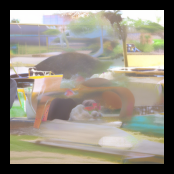

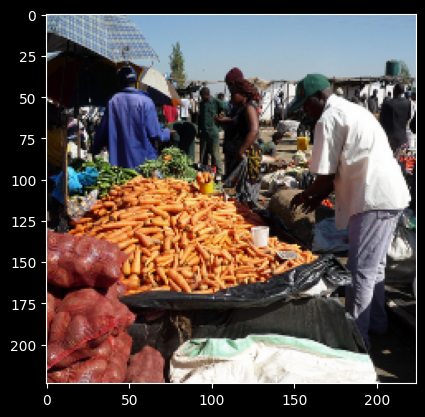

  0%|          | 0/1000 [03:57<?, ?it/s]

singlesubject_subj01_40sess_prior


NameError: name 'err' is not defined

In [26]:
# get all reconstructions
model.to(device)
model.eval().requires_grad_(False)

# all_images = None
all_blurryrecons = None
all_recons = None
all_predcaptions = []
all_clipvoxels = None

minibatch_size = 1
num_samples_per_image = 1
assert num_samples_per_image == 1

if utils.is_interactive(): plotting=True
# plotting = False

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    for batch in tqdm(range(0,len(np.unique(test_images_idx)),minibatch_size)):
        uniq_imgs = np.unique(test_images_idx)[batch:batch+minibatch_size]
        voxel = None
        for uniq_img in uniq_imgs:
            locs = np.where(test_images_idx==uniq_img)[0]
            if len(locs)==1:
                locs = locs.repeat(3)
            elif len(locs)==2:
                locs = locs.repeat(2)[:3]
            assert len(locs)==3
            if voxel is None:
                voxel = test_voxels[None,locs] # 1, num_image_repetitions, num_voxels
            else:
                voxel = torch.vstack((voxel, test_voxels[None,locs]))
        voxel = voxel.to(device)
        
        for rep in range(3):
            voxel_ridge = model.ridge(voxel[:,[rep]],0) # 0th index of subj_list
            backbone0, clip_voxels0, blurry_image_enc0 = model.backbone(voxel_ridge)
            if rep==0:
                clip_voxels = clip_voxels0
                backbone = backbone0
                blurry_image_enc = blurry_image_enc0[0]
            else:
                clip_voxels += clip_voxels0
                backbone += backbone0
                blurry_image_enc += blurry_image_enc0[0]
        clip_voxels /= 3
        backbone /= 3
        blurry_image_enc /= 3
                
        # Save retrieval submodule outputs
        if all_clipvoxels is None:
            all_clipvoxels = clip_voxels.cpu()
        else:
            all_clipvoxels = torch.vstack((all_clipvoxels, clip_voxels.cpu()))
        
        # Feed voxels through OpenCLIP-bigG diffusion prior
        prior_out = model.diffusion_prior.p_sample_loop(backbone.shape, 
                        text_cond = dict(text_embed = backbone), 
                        cond_scale = 1., timesteps = 20)
        
        pred_caption_emb = clip_convert(prior_out)
        generated_ids = clip_text_model.generate(pixel_values=pred_caption_emb, max_length=20)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
        all_predcaptions = np.hstack((all_predcaptions, generated_caption))
        print(generated_caption)
        
        # Feed diffusion prior outputs through unCLIP
        for i in range(len(voxel)):
            samples = utils.unclip_recon(prior_out[[i]],
                             diffusion_engine,
                             vector_suffix,
                             num_samples=num_samples_per_image)
            if all_recons is None:
                all_recons = samples.cpu()
            else:
                all_recons = torch.vstack((all_recons, samples.cpu()))
            if plotting:
                for s in range(num_samples_per_image):
                    plt.figure(figsize=(2,2))
                    plt.imshow(transforms.ToPILImage()(samples[s]))
                    plt.axis('off')
                    plt.show()

        if blurry_recon:
            blurred_image = (autoenc.decode(blurry_image_enc/0.18215).sample/ 2 + 0.5).clamp(0,1)
            
            for i in range(len(voxel)):
                im = torch.Tensor(blurred_image[i])
                if all_blurryrecons is None:
                    all_blurryrecons = im[None].cpu()
                else:
                    all_blurryrecons = torch.vstack((all_blurryrecons, im[None].cpu()))
                if plotting:
                    plt.figure(figsize=(2,2))
                    plt.imshow(transforms.ToPILImage()(im))
                    plt.axis('off')
                    plt.show()

        if plotting: 
            print(model_name)
            err # dont actually want to run the whole thing with plotting=True

# resize outputs before saving
imsize = 256
all_recons = transforms.Resize((imsize,imsize))(all_recons).float()
if blurry_recon: 
    all_blurryrecons = transforms.Resize((imsize,imsize))(all_blurryrecons).float()
        
# saving
print(all_recons.shape)
# # You can find the all_images file on huggingface: https://huggingface.co/datasets/pscotti/mindeyev2/tree/main/evals
# torch.save(all_images,"evals/all_images.pt") 
if blurry_recon:
    torch.save(all_blurryrecons,f"~/playground/BrainGen/checkpoints/NSD/evals/{model_name}/{model_name}_all_blurryrecons.pt")
torch.save(all_recons,f"~/playground/BrainGen/checkpoints/NSD/evals/{model_name}/{model_name}_all_recons.pt")
torch.save(all_predcaptions,f"~/playground/BrainGen/checkpoints/NSD/evals/{model_name}/{model_name}_all_predcaptions.pt")
torch.save(all_clipvoxels,f"~/playground/BrainGen/checkpoints/NSD/evals/{model_name}/{model_name}_all_clipvoxels.pt")
print(f"saved {model_name} outputs!")

if not utils.is_interactive():
    sys.exit(0)